In [57]:
# pip install -U imbalanced-learn

# pip install xgboost


In [58]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.compose import make_column_transformer
import numpy as np
# from imblearn.over_sampling import SMOTENC
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

# from xgboost import XGBClassifier



In [59]:
credit = pd.read_csv('credit_record.csv')

In [60]:
application = pd.read_csv('application_record.csv')

### data preview

In [61]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [62]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [63]:
application.describe().drop(columns=['ID'],axis=1)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


### dealing some invalid values in employed days col and occupation col

In [64]:
application.DAYS_EMPLOYED.replace(to_replace=365243, value=np.nan, inplace=True)
application.OCCUPATION_TYPE.replace(to_replace=np.nan, value='Unknown', inplace=True)

In [65]:
application['DAYS_EMPLOYED']=application.DAYS_EMPLOYED.apply(lambda x: -x/365.25)
application['DAYS_BIRTH']=application.DAYS_BIRTH.apply(lambda x: -x/365.25)

### use day_birth to train a linear regression model to fill employed days' nan value

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='DAYS_EMPLOYED'>

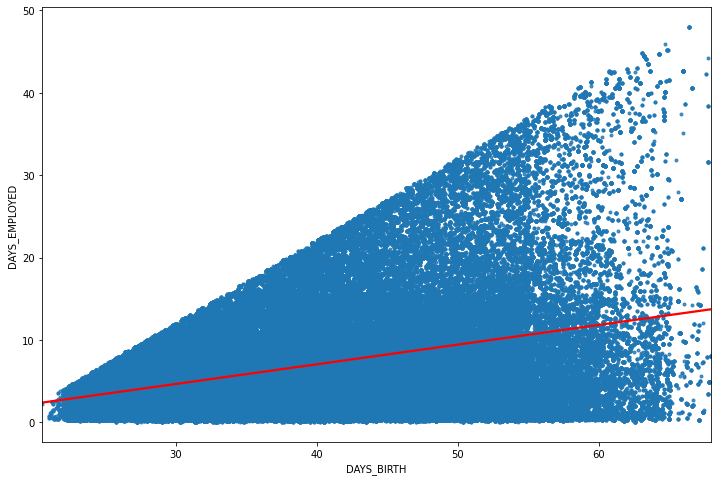

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.regplot(x='DAYS_BIRTH', y='DAYS_EMPLOYED', data=application, marker='.',line_kws={'color': 'r'} )
# use lm to predict and fill the nan value in employday

###  table 1 data preprocess

In [67]:
app = application.drop_duplicates(subset=application.columns[1:], keep='first')

In [68]:
birth_emp = app[(app.DAYS_BIRTH.notna())&(app.DAYS_EMPLOYED.notna())]

In [69]:
birth_emp.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,1,0,0,Unknown,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,1,0,1,1,Sales staff,1.0
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,1,Accountants,2.0
13,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,48.673511,3.268994,1,0,0,0,Laborers,2.0


In [70]:
X_fillemp= birth_emp['DAYS_BIRTH'].values.reshape(-1 ,1)
y_fillemp = birth_emp['DAYS_EMPLOYED'].values.reshape(-1)


In [71]:
lm = LinearRegression().fit(X_fillemp, y_fillemp)

In [72]:
app.DAYS_EMPLOYED.isna().sum()

15687

In [73]:
app[app['DAYS_EMPLOYED'].isna()][['DAYS_BIRTH', 'DAYS_EMPLOYED']]

,DAYS_BIRTH,DAYS_EMPLOYED
7,61.503080,NaN
76,55.266256,NaN
160,61.106092,NaN
216,51.148528,NaN
239,61.138946,NaN
...,...,...
438449,58.527036,NaN
438499,53.221081,NaN
438525,59.608487,NaN
438545,51.559206,NaN


### use linear model to fill nan value 

In [74]:
app['DAYS_EMPLOYED'] = app[['DAYS_BIRTH', 'DAYS_EMPLOYED']].apply(
    lambda x :lm.predict(np.array([x['DAYS_BIRTH']]).reshape(1,-1))[0] 
    if pd.isna(x['DAYS_EMPLOYED']) else x["DAYS_EMPLOYED"], axis=1)

<ipython-input-74-bf40a1b6a77f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app['DAYS_EMPLOYED'] = app[['DAYS_BIRTH', 'DAYS_EMPLOYED']].apply(


In [75]:
app.DAYS_EMPLOYED.isna().sum()

0

In [76]:
app[['DAYS_BIRTH', 'DAYS_EMPLOYED']].head()

,DAYS_BIRTH,DAYS_EMPLOYED
0,32.867899,12.435318
2,58.792608,3.104723
3,52.320329,8.353183
7,61.503080,11.534787
10,46.193018,2.105407


In [77]:
app.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'car',
    'FLAG_OWN_REALTY': 'realty',
    'CNT_CHILDREN': 'num_of_children',
    'AMT_INCOME_TOTAL': 'total_income',
    'NAME_INCOME_TYPE': 'income_resource',
    'NAME_EDUCATION_TYPE': 'edu_level',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'DAYS_BIRTH': 'age',
    'DAYS_EMPLOYED': 'employed_years',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE':'phone',
    'FLAG_EMAIL': 'email',
    'OCCUPATION_TYPE':'occupation',
    'CNT_FAM_MEMBERS': 'num_of_fam_member',
}, inplace=True)

/Users/zihaoli/opt/anaconda3/envs/DA/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [78]:
app.drop(labels=['mobile'], axis=1, inplace=True)

/Users/zihaoli/opt/anaconda3/envs/DA/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [79]:
app.isna().sum()

ID                   0
gender               0
car                  0
realty               0
num_of_children      0
total_income         0
income_resource      0
edu_level            0
family_status        0
housing_type         0
age                  0
employed_years       0
work_phone           0
phone                0
email                0
occupation           0
num_of_fam_member    0
dtype: int64

In [80]:
app.num_of_fam_member.fillna(value=app.num_of_fam_member.mean(), inplace=True)

/Users/zihaoli/opt/anaconda3/envs/DA/lib/python3.8/site-packages/pandas/core/series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [81]:
app.describe().drop('ID', axis=1)

,num_of_children,total_income,age,employed_years,work_phone,phone,email,num_of_fam_member
count,90085.000000,9.008500e+04,90085.000000,90085.000000,90085.000000,90085.000000,90085.000000,90085.000000
mean,0.423811,1.787001e+05,43.536247,7.433892,0.202953,0.274496,0.100228,2.177288
std,0.726697,1.024630e+05,11.650874,6.006665,0.402200,0.446263,0.300305,0.904672
min,0.000000,2.610000e+04,20.503765,0.032854,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.125000e+05,33.782341,2.696783,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.575000e+05,42.617385,6.258727,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,53.193703,10.971744,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,68.996578,47.997262,1.000000,1.000000,1.000000,20.000000


#### based on min and max value of describe df above , we found that some outlier are in chilren, emplyed_days and family member column

In [82]:
app.employed_years.value_counts()

0.596851     62
1.177276     61
0.632444     59
0.635181     53
0.594114     53
             ..
19.827515     1
19.800137     1
12.655874     1
25.544148     1
29.976728     1
Name: employed_years, Length: 15252, dtype: int64

In [83]:
app.num_of_children.value_counts()

0     62723
1     18026
2      8075
3      1114
4       114
5        25
6         2
7         2
9         1
12        1
14        1
19        1
Name: num_of_children, dtype: int64

In [84]:
app.num_of_fam_member.value_counts()

2.0     47397
1.0     18389
3.0     15631
4.0      7483
5.0      1047
6.0       106
7.0        24
8.0         2
9.0         2
15.0        1
20.0        1
14.0        1
11.0        1
Name: num_of_fam_member, dtype: int64

In [85]:
app_new = app[(app.employed_years<100)&(app.num_of_children<10)]

In [86]:
app_new['num_of_fam_member']=app_new.num_of_fam_member.astype('int')

<ipython-input-86-fcf18807fdaa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_new['num_of_fam_member']=app_new.num_of_fam_member.astype('int')


In [87]:
app_new

,ID,gender,car,realty,num_of_children,total_income,income_resource,edu_level,family_status,housing_type,age,employed_years,work_phone,phone,email,occupation,num_of_fam_member
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,0,0,Unknown,2
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,0,0,0,Security staff,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,0,1,1,Sales staff,1
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.503080,11.534787,0,0,0,Unknown,1
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,Accountants,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438541,6837707,M,N,Y,0,202500.0,Working,Higher education,Civil marriage,House / apartment,36.988364,6.321697,1,0,0,Laborers,2
438545,6839651,F,N,Y,3,99000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,51.559206,9.265117,0,0,0,Unknown,1
438547,6839917,F,N,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,30.023272,7.403149,0,0,0,Unknown,2
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.195756,11.692889,0,0,0,Unknown,1


### table 2 data preprocess

In [88]:
credit.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [89]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


### looks like there is no outlier value. We seperate the potential applicants of high and low risk by STATUS == 3 that the customers did not pay credit card bill after 3 months later of the due day. we can ignore the month feature and only reference the status feature

In [90]:
# credit['STATUS'] = credit.STATUS.apply(lambda x : 0 if x in ('X' 'C'))
credit.STATUS.replace('X', -1, inplace=True)
credit.STATUS.replace('C', -1, inplace=True)

credit['STATUS'] = credit.STATUS.astype('int')
credit_record = credit.groupby('ID').STATUS.max()

In [91]:
df = app_new.merge(credit_record, how='inner', on='ID')

In [92]:
df.head(20)

,ID,gender,car,realty,num_of_children,total_income,income_resource,edu_level,family_status,housing_type,age,employed_years,work_phone,phone,email,occupation,num_of_fam_member,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,0,0,Unknown,2,1
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,0,0,0,Security staff,2,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,0,1,1,Sales staff,1,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.503080,11.534787,0,0,0,Unknown,1,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,Accountants,2,0
5,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,48.673511,3.268994,0,0,0,Laborers,2,-1
6,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29.210130,3.019849,0,0,0,Accountants,2,1
7,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,27.463381,4.021903,0,1,0,Laborers,2,1
8,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,30.028747,4.435318,0,0,0,Unknown,2,0
9,5008836,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,34.740589,3.184120,0,0,0,Laborers,5,0


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9707 entries, 0 to 9706
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 9707 non-null   int64  
 1   gender             9707 non-null   object 
 2   car                9707 non-null   object 
 3   realty             9707 non-null   object 
 4   num_of_children    9707 non-null   int64  
 5   total_income       9707 non-null   float64
 6   income_resource    9707 non-null   object 
 7   edu_level          9707 non-null   object 
 8   family_status      9707 non-null   object 
 9   housing_type       9707 non-null   object 
 10  age                9707 non-null   float64
 11  employed_years     9707 non-null   float64
 12  work_phone         9707 non-null   int64  
 13  phone              9707 non-null   int64  
 14  email              9707 non-null   int64  
 15  occupation         9707 non-null   object 
 16  num_of_fam_member  9707 

In [94]:
df.describe()

,ID,num_of_children,total_income,age,employed_years,work_phone,phone,email,num_of_fam_member,STATUS
count,9.707000e+03,9707.000000,9.707000e+03,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000
mean,5.076103e+06,0.419491,1.812308e+05,43.784089,7.595731,0.217369,0.287627,0.087566,2.179458,0.065314
std,4.080556e+04,0.730670,9.928409e+04,11.625815,6.020474,0.412477,0.452680,0.282677,0.906020,0.701665
min,5.008804e+06,0.000000,2.700000e+04,20.503765,0.046543,0.000000,0.000000,0.000000,1.000000,-1.000000
25%,5.036954e+06,0.000000,1.125000e+05,34.060233,2.844627,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.069449e+06,0.000000,1.575000e+05,42.740589,6.499658,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.112986e+06,1.000000,2.250000e+05,53.567420,11.058080,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150479e+06,7.000000,1.575000e+06,68.862423,43.019849,1.000000,1.000000,1.000000,9.000000,5.000000


In [95]:
df['decline'] = df.STATUS.apply(lambda x : 1 if x in ( 2, 3, 4, 5) else 0)

In [96]:
df.decline.value_counts()

0    9501
1     206
Name: decline, dtype: int64

### so we can see this is inbalance datasets, which may cause some bias when the data implemented in ML training; hence we can use SMOTE NC algorithm to "create" some data to make sure that we can even labels

In [101]:
df_new = pd.get_dummies(data=df, columns=['gender', 'car', 'realty', 'income_resource', 'edu_level', 'family_status','housing_type',])

In [102]:
df_new.head()

,ID,num_of_children,total_income,age,employed_years,work_phone,phone,email,occupation,num_of_fam_member,...,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow,housing_type_Co-op apartment,housing_type_House / apartment,housing_type_Municipal apartment,housing_type_Office apartment,housing_type_Rented apartment,housing_type_With parents
0,5008804,0,427500.0,32.867899,12.435318,1,0,0,Unknown,2,...,0,0,0,0,0,0,0,0,1,0
1,5008806,0,112500.0,58.792608,3.104723,0,0,0,Security staff,2,...,1,0,0,0,0,1,0,0,0,0
2,5008808,0,270000.0,52.320329,8.353183,0,1,1,Sales staff,1,...,0,0,1,0,0,1,0,0,0,0
3,5008812,0,283500.0,61.503080,11.534787,0,0,0,Unknown,1,...,0,1,0,0,0,1,0,0,0,0
4,5008815,0,270000.0,46.193018,2.105407,1,1,1,Accountants,2,...,1,0,0,0,0,1,0,0,0,0


/Users/zihaoli/opt/anaconda3/envs/DA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_income', ylabel='occupation'>

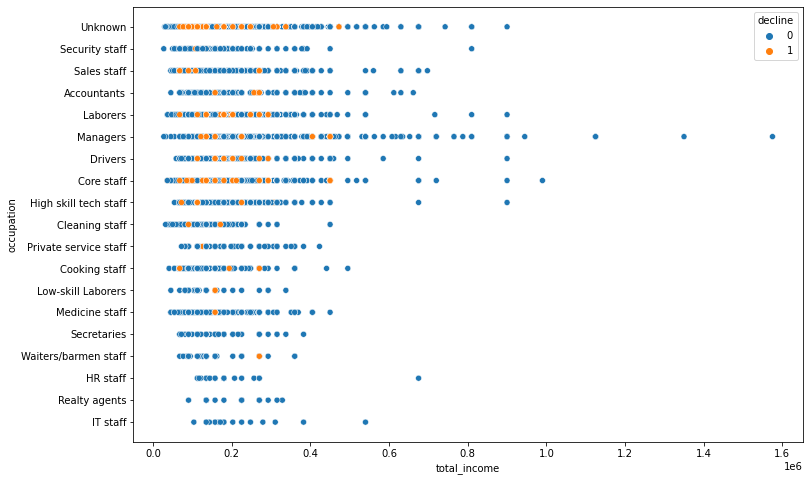

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.scatterplot(df_new['total_income'],df_new['occupation'],hue=df['decline'])

### IV begin

In [43]:
X = df_new.drop(columns=['ID','STATUS','decline'],axis=1)
y = df_new.decline

In [44]:
X.columns

Index(['num_of_children', 'total_income', 'age', 'employed_years',
       'work_phone', 'phone', 'email', 'num_of_fam_member', 'gender_F',
       'gender_M', 'car_N', 'car_Y', 'realty_N', 'realty_Y',
       'income_resource_Commercial associate', 'income_resource_Pensioner',
       'income_resource_State servant', 'income_resource_Student',
       'income_resource_Working', 'edu_level_Academic degree',
       'edu_level_Higher education', 'edu_level_Incomplete higher',
       'edu_level_Lower secondary', 'edu_level_Secondary / secondary special',
       'family_status_Civil marriage', 'family_status_Married',
       'family_status_Separated', 'family_status_Single / not married',
       'family_status_Widow', 'housing_type_Co-op apartment',
       'housing_type_House / apartment', 'housing_type_Municipal apartment',
       'housing_type_Office apartment', 'housing_type_Rented apartment',
       'housing_type_With parents', 'occupation_Accountants',
       'occupation_Cleaning staff', '

In [45]:
len(X.columns)

54

In [46]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: decline, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [48]:
# smotenc = SMOTENC([4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53],random_state = 42) 

In [49]:
# X_over, y_over = smotenc.fit_resample(X_train, y_train)

In [50]:
# s1 = StandardScaler().fit(X_over)

NameError: name 'X_over' is not defined

In [ ]:
# X_over = s1.transform(X_over)

In [ ]:
# X_overtest = s1.transform(X_test)

In [51]:
s2 = StandardScaler().fit(X_train)

In [52]:
X_train = s2.transform(X_train)

In [53]:
X_train_test = s2.transform(X_test)

### first we try some single classifier such as Ridge and logistic regression

In [54]:
classifiers = {
    'Ridge': RidgeClassifier(),
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    'Adaboost':AdaBoostClassifier(),
    'Voting': VotingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)), 
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)), 
        ('tree', DecisionTreeClassifier(random_state=42)),
        ], voting='hard'),
        }    

# 用metric recall score 去查准。确保准确率

In [55]:
for key, classifier in classifiers.items():
    classifier.fit(X_over, y_over)
    y_pred = classifier.predict(X_overtest)
    score = recall_score(y_test, y_pred)
    print(f'current clf: {key}')
    print(f'test data score: {score}')
    plot_confusion_matrix(classifier, X_overtest, y_test)
    plt.show()
    print('-'*40)

NameError: name 'X_over' is not defined

current clf: Ridge
test data score: 0.0


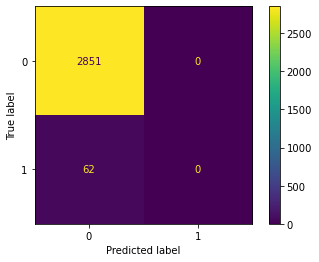

----------------------------------------
current clf: LogisticRegression
test data score: 0.0


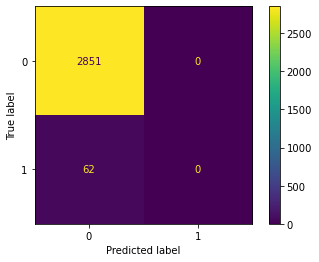

----------------------------------------
current clf: KNeighbors
test data score: 0.03225806451612903


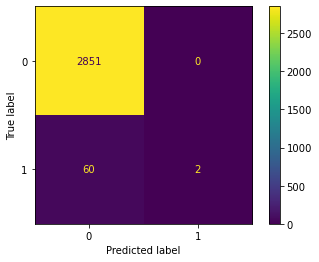

----------------------------------------
current clf: DecisionTree
test data score: 0.22580645161290322


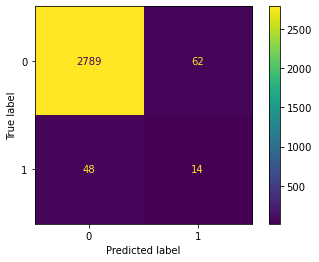

----------------------------------------
current clf: RandomForest
test data score: 0.016129032258064516


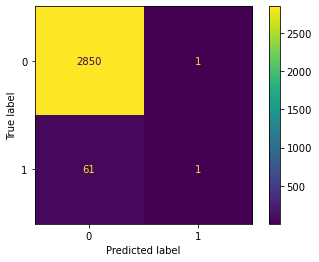

----------------------------------------
current clf: Adaboost
test data score: 0.0


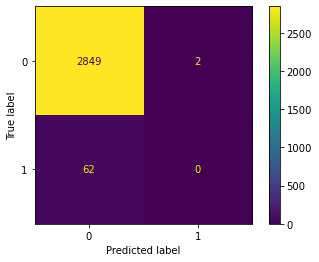

----------------------------------------
current clf: Voting
test data score: 0.016129032258064516


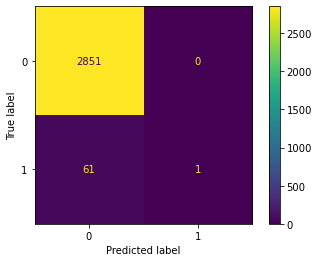

----------------------------------------


In [56]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_train_test)
    score = recall_score(y_test, y_pred)
    print(f'current clf: {key}')
    print(f'test data score: {score}')
    plot_confusion_matrix(classifier, X_train_test, y_test)
    plt.show()
    print('-'*40)